In [39]:
from matrix_model import Market
from model_irf import Market as Market_IRF
import numpy as np
import json
import matplotlib.pyplot as plt

In [40]:
fontsize= 18
ticksize = 16
figsize = (9, 9)
plot_params = {'font.family':'serif',
        "figure.figsize":figsize, 
        'figure.dpi': 80,
        'figure.edgecolor': 'k',
        'font.size': fontsize, 
        'axes.labelsize': fontsize,
        'axes.titlesize': fontsize,
        'xtick.labelsize': ticksize,
        'ytick.labelsize': ticksize,
        'legend.fontsize': fontsize,
        'legend.markerscale': 2.0
    }
plt.rcParams.update(plot_params) 

In [41]:
params = {
    "save_timeseries_data": 1, 
    "total_steps": 1500,
    "compression_factor": 1,
    "I": 200,
    "network_density": 0.1,
    "prob_rewire": 0.01,
    "set_seed": 11,
    "R": 1.0001,
    "a": 5.5,
    "d": 0.021,
    "theta_mean" : 0.0,
    "theta_sigma" :1.24,
    "epsilon_sigma": 1,
    "gamma_mean" : 0.0,
    "gamma_sigma" :1.46,
    "proportion_informed": 0.05,
    "proportion_misinformed": 0.05,
    "ar_1_coefficient": 0.5,
    "network_type": "scale_free",
    "w": 0.9,
    "misinformed_central": 0
}

In [42]:
financial_market = Market(params)
# run the market
while financial_market.step_count < params["total_steps"]:
    financial_market.next_step()

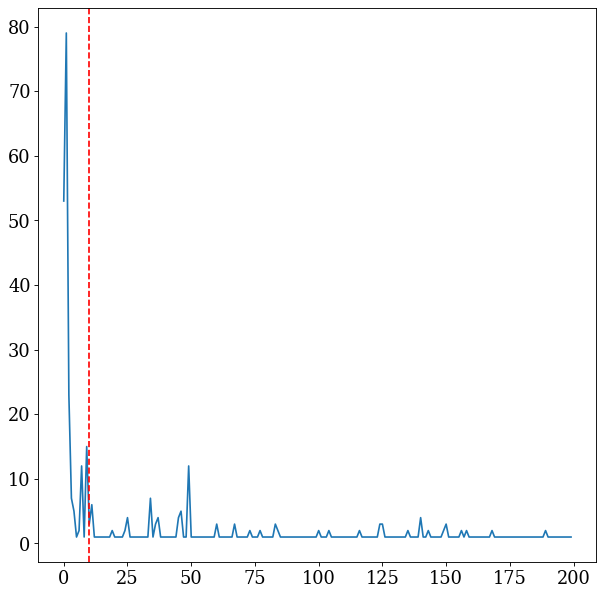

In [43]:
adj = financial_market.adjacency_matrix
#put nans to zeros
adj = np.nan_to_num(adj)
#plot the sum over rows
plt.figure()
plt.plot(np.sum(adj, axis=0))
#add vertical line at 10
plt.axvline(x=10, color='r', linestyle='--')

In [44]:
adj.max()

1.0

In [45]:
financial_market.category_vector

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0

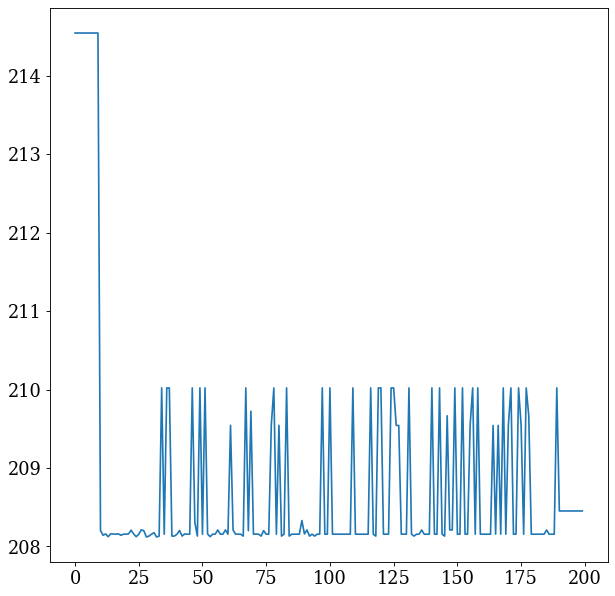

In [46]:
plt.plot(financial_market.payoff_expectation)

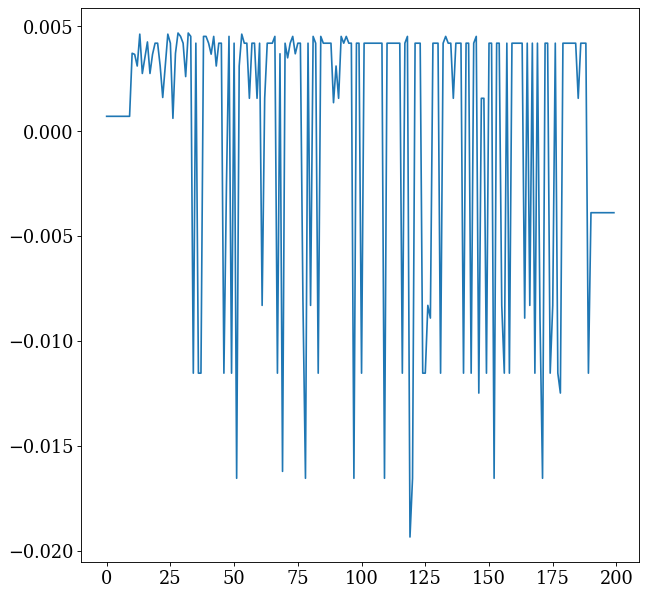

In [47]:
plt.plot(financial_market.profits)

In [48]:
returns = np.asarray(financial_market.history_p_t[1:]) / np.asarray(financial_market.history_p_t[:-1]) - 1
skeweness = np.mean((returns - np.mean(returns))**3) / np.std(returns)**3
kurtosis = np.mean((returns - np.mean(returns))**4) / np.std(returns)**4

In [49]:
lamb = params["proportion_informed"]
xi = params["proportion_misinformed"]

theta = np.zeros(params["total_steps"])
gamma = np.zeros_like(theta)
theta[0] = params["theta_mean"]
gamma[0] = params["theta_mean"]
expected_uninfo_theta = np.zeros_like(theta)
expected_uninfo_theta[0] = params["theta_mean"]
for t in range(1,params["total_steps"]):
    theta[t] = params["ar_1_coefficient"] * theta[t-1] + params["theta_sigma"] * np.random.randn()
    gamma[t] = params["ar_1_coefficient"] * gamma[t-1] + params["gamma_sigma"] * np.random.randn()
    expected_uninfo_theta[t] = lamb * theta[t] + params["proportion_misinformed"] * gamma[t] + (1 - lamb - params["proportion_misinformed"]) * expected_uninfo_theta[t-1]

price_baseline = params["d"] / (params["R"] - 1) + \
    (lamb * theta * (params["R"] - params["ar_1_coefficient"])) / ((params["R"] - params["ar_1_coefficient"]) * params["epsilon_sigma"] ** 2 + params["theta_sigma"] ** 2) + \
    (xi * gamma * (params["R"] - params["ar_1_coefficient"])) / ((params["R"] - params["ar_1_coefficient"]) * params["epsilon_sigma"] ** 2 + params["gamma_sigma"] ** 2)


variance_info = params["epsilon_sigma"] ** 2 + params["theta_sigma"]**2 / (params["R"] - params["ar_1_coefficient"])**2
variance_misinfo = params["epsilon_sigma"] ** 2 + params["gamma_sigma"]**2 / (params["R"] - params["ar_1_coefficient"])**2
variance_uninfo = params["epsilon_sigma"] ** 2 + params["theta_sigma"]**2 / params["I"]


price_degroot = params["d"] / (params["R"] - 1) + \
    (lamb * theta * variance_misinfo * variance_uninfo + \
    xi * gamma * variance_info * variance_uninfo + \
    (1 - lamb - xi) * expected_uninfo_theta * variance_info * variance_misinfo) / \
    (lamb * variance_misinfo * variance_uninfo + xi * variance_info * variance_uninfo + (1 - lamb - xi) * variance_info * variance_misinfo) / \
    (params["R"] - params["ar_1_coefficient"])

In [50]:
returns_baseline = price_baseline[1:] / price_baseline[:-1] - 1
returns_degroot = price_degroot[1:] / price_degroot[:-1] - 1

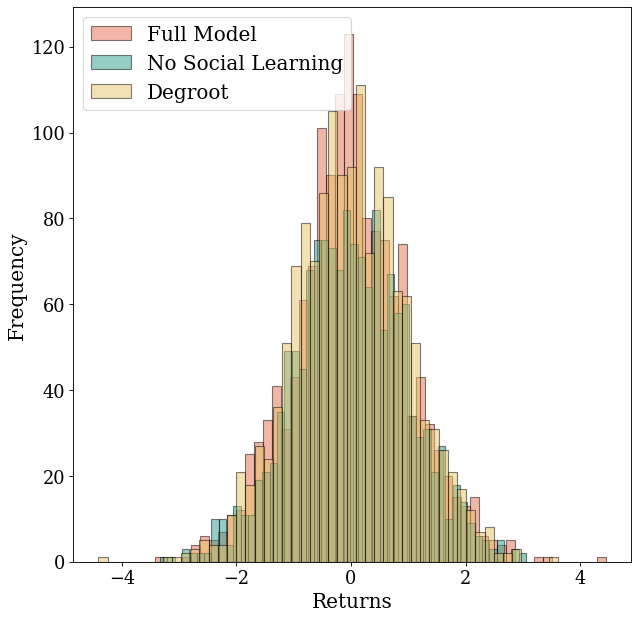

In [51]:
fig, ax = plt.subplots(figsize = (9,9))
#normalize the returns
returns_baseline = (returns_baseline - np.mean(returns_baseline)) / np.std(returns_baseline)
returns_degroot = (returns_degroot - np.mean(returns_degroot)) / np.std(returns_degroot)
returns = (returns - np.mean(returns)) / np.std(returns)
ax.hist(returns, bins=50, alpha=0.5, color="#E76F51", edgecolor='black', density = False, label='Full Model')
ax.hist(returns_baseline, bins=50, alpha=0.5, color='#2A9D8F', edgecolor='black', density = False, label="No Social Learning")
ax.hist(returns_degroot, bins=50, alpha=0.5, color = "#E9C46A", edgecolor = 'black', density = False, label="Degroot")
# #overlay a normal distribution
# x = np.linspace(-4,4,100)
# y = 1/(np.sqrt(2*np.pi)) * np.exp(-0.5*x**2)
# ax.plot(x,y, 'k--', label='Normal Distribution')
#axes labels
ax.set_xlabel('Returns')
ax.set_ylabel('Frequency')
ax.legend()
#save the figure
#plt.savefig('Figures/returns_histogram.png')
plt.show()


In [52]:
print("Skeweness: ", skeweness)
print("Kurtosis: ", kurtosis)
print("Baseline Skeweness: ", np.mean((returns_baseline - np.mean(returns_baseline))**3) / np.std(returns_baseline)**3)
print("Baseline Kurtosis: ", np.mean((returns_baseline - np.mean(returns_baseline))**4) / np.std(returns_baseline)**4)
print("Degroot Skeweness: ", np.mean((returns_degroot - np.mean(returns_degroot))**3) / np.std(returns_degroot)**3)
print("Degroot Kurtosis: ", np.mean((returns_degroot - np.mean(returns_degroot))**4) / np.std(returns_degroot)**4)


Skeweness:  0.10331261750327925
Kurtosis:  3.382754896217242
Baseline Skeweness:  -0.007821408580394922
Baseline Kurtosis:  3.063511393400195
Degroot Skeweness:  -0.026599968536916405
Degroot Kurtosis:  3.220028633154673


In [53]:
# add the parameters we need for the IRF model
params_irf = params.copy()
params_irf["shock_time"] = 10
params_irf["total_steps"] = 30
params_irf["weighting_matrix"] = financial_market.weighting_matrix
params_irf["posterior_variance_vector"] = financial_market.posterior_variance_vector

In [54]:
params_irf["shock_type"] = "information"
financial_market_irf = Market_IRF(params_irf)
# run the market
while financial_market_irf.step_count < params_irf["total_steps"]:
    financial_market_irf.next_step()

In [55]:
params_irf["shock_type"] = "misinformation"
financial_market_irf_misinfo = Market_IRF(params_irf)
# run the market
while financial_market_irf_misinfo.step_count < params_irf["total_steps"]:
    financial_market_irf_misinfo.next_step()

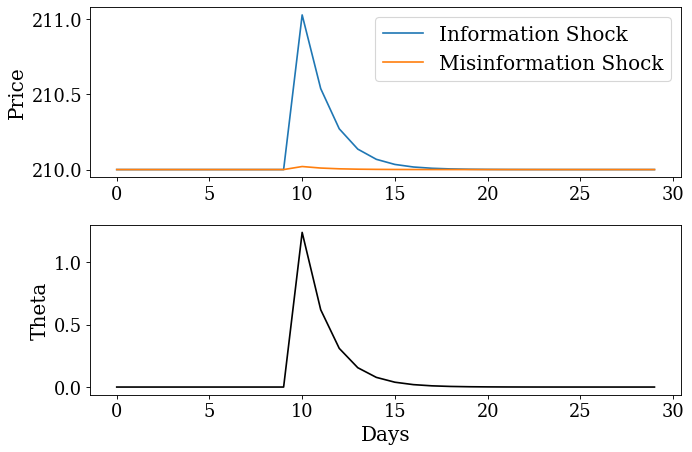

In [56]:
fig, axs = plt.subplots(2,1, figsize = (9,6))
axs[0].plot(np.asarray(financial_market_irf.history_p_t), label = 'Information Shock')
axs[0].set_ylabel('Price')
#twinx the axis
axs[0].plot(np.asarray(financial_market_irf_misinfo.history_p_t), label = 'Misinformation Shock')
axs[0].legend()
axs[1].plot(financial_market_irf.history_theta_t, label = 'Shock', color = "black")
axs[1].set_ylabel('Theta')
axs[1].set_xlabel('Days')

ax.legend()
plt.tight_layout()


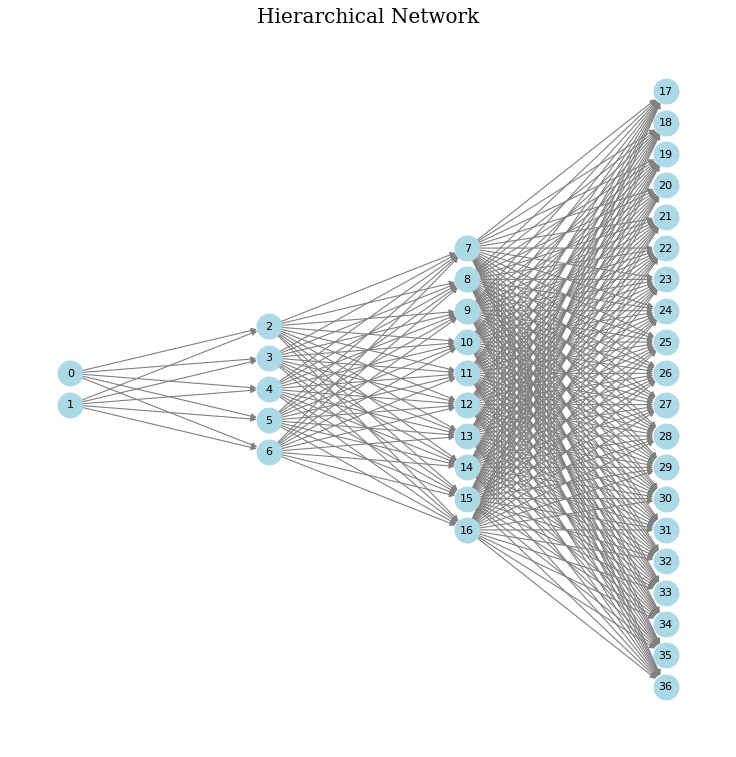

In [57]:
import networkx as nx
import matplotlib.pyplot as plt

def generate_hierarchical_network(layers, nodes_per_layer):
    """
    Generate a hierarchical directed network.

    Parameters:
        layers (int): Number of layers in the hierarchy.
        nodes_per_layer (list): A list specifying the number of nodes in each layer.

    Returns:
        G (DiGraph): A directed hierarchical network.
    """
    if len(nodes_per_layer) != layers:
        raise ValueError("Length of nodes_per_layer must match the number of layers.")

    G = nx.DiGraph()
    
    # Create nodes layer by layer
    current_node = 0
    previous_layer_nodes = []

    for layer in range(layers):
        # Add nodes for the current layer
        layer_nodes = list(range(current_node, current_node + nodes_per_layer[layer]))
        G.add_nodes_from(layer_nodes, layer=layer)

        # Connect previous layer nodes to current layer nodes
        if previous_layer_nodes:
            for src in previous_layer_nodes:
                for tgt in layer_nodes:
                    G.add_edge(src, tgt)

        # Update for the next iteration
        previous_layer_nodes = layer_nodes
        current_node += nodes_per_layer[layer]

    return G

def plot_hierarchical_network(G):
    """Visualize the hierarchical network."""
    pos = nx.multipartite_layout(G, subset_key="layer")  # Use layer info for layout
    nx.draw(G, pos, with_labels=True, node_color="lightblue", edge_color="gray", node_size=500, font_size=10)
    plt.title("Hierarchical Network")
    plt.show()

# Parameters for the hierarchical network
layers = 4
nodes_per_layer = [2, 5, 10, 20]  # Number of nodes in each layer

# Generate and visualize the network
G = generate_hierarchical_network(layers, nodes_per_layer)
plot_hierarchical_network(G)
